In [1]:
import os
import sys
sys.path.append(os.path.abspath('../../../..'))

import numpy as np
import pandas as pd

# from utlis.corr_utlis.processed_syned_load import load_filtered_data_from_h5

In [26]:
rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

In [27]:
# List of keypoints to analyze (indices)
head_keypoints = [1, 2, 3, 4]  # Example: EarL, EarR, Snout, SpineF
# z_columns = [f'kp{idx}_z' for idx in keypoints_of_interest]
# head_coords = df_merged_with_dF_F[[f"kp{idx}_{axis}" for idx in head_keypoints for axis in ['x', 'y', 'z']]].copy()
# Define head keypoints
# head_keypoints = ['1', '2', '3', '4']  # Adjust based on your setup (e.g., EarL, EarR, Snout, SpineF)

# Adjust for egocentric coordinates
if 'com_x' in df_merged_with_dF_F.columns and 'com_y' in df_merged_with_dF_F.columns and 'com_z' in df_merged_with_dF_F.columns:
    head_coords = df_merged_with_dF_F[
        [f"kp{idx}_{axis}" for idx in head_keypoints for axis in ['x', 'y', 'z']]
    ].copy()

    for axis in ['x', 'y', 'z']:
        com_col = f'com_{axis}'
        if com_col in df_merged_with_dF_F.columns:
            head_coords[[f"kp{idx}_{axis}" for idx in head_keypoints]] -= df_merged_with_dF_F[com_col].values[:, None]
        else:
            print(f"Warning: {com_col} not found. Cannot adjust for egocentric {axis} coordinates.")
else:
    print("COM columns (com_x, com_y, com_z) not found. Using absolute coordinates.")

# Result: head_coords now contains egocentric coordinates for each head keypoint.



In [32]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def rigid_body_transform_and_angles(current, template):
    centroid_current = np.mean(current, axis=0)
    centroid_template = np.mean(template, axis=0)

    current_centered = current - centroid_current
    template_centered = template - centroid_template

    H = current_centered.T @ template_centered
    U, _, Vt = np.linalg.svd(H)
    R_matrix = Vt.T @ U.T

    if np.linalg.det(R_matrix) < 0:
        Vt[-1, :] *= -1
        R_matrix = Vt.T @ U.T

    t = centroid_template - R_matrix @ centroid_current
    rotation = R.from_matrix(R_matrix)
    angles = rotation.as_euler('xyz', degrees=True)  # Pitch, yaw, roll
    return R_matrix, t, angles

# Egocentric adjustment
head_coords = df_merged_with_dF_F[
    [f"kp{idx}_{axis}" for idx in head_keypoints for axis in ['x', 'y', 'z']]
].copy()

for axis in ['x', 'y', 'z']:
    com_col = f'com_{axis}'
    if com_col in df_merged_with_dF_F.columns:
        head_coords.loc[:, [f"kp{idx}_{axis}" for idx in head_keypoints]] -= df_merged_with_dF_F[com_col].values[:, None]

# Select template
template_time = head_coords.apply(lambda row: np.var(row.values.reshape(-1, 3)), axis=1).idxmin()
template_coords = head_coords.loc[template_time].values.reshape(-1, 3)

# Apply transformation and extract angles
results = head_coords.apply(
    lambda row: rigid_body_transform_and_angles(row.values.reshape(-1, 3), template_coords),
    axis=1
)

# Add angles to DataFrame
df_merged_with_dF_F['head_pitch'] = results.apply(lambda x: x[2][0])  # Pitch
df_merged_with_dF_F['head_yaw'] = results.apply(lambda x: x[2][1])    # Yaw
df_merged_with_dF_F['head_roll'] = results.apply(lambda x: x[2][2])   # Roll


In [33]:
df_merged_with_dF_F

,com_x,com_y,com_z,kp1_x,kp1_y,kp1_z,kp2_x,kp2_y,kp2_z,kp3_x,...,dF_F_roi80,dF_F_roi81,dF_F_roi82,dF_F_roi83,dF_F_roi84,dF_F_roi85,dF_F_roi86,head_pitch,head_yaw,head_roll
timestamp_ms_mini,,,,,,,,,,,,,,,,,,,,,
-28,41.706841,527.997575,10.797444,13.583969,533.438843,19.441160,35.926529,553.407898,19.521400,10.872994,...,0.456811,1.014832,1.502012,2.116763,4.093864,-0.077933,0.503355,-21.822253,-46.105776,-105.525291
76,41.555597,528.230113,9.798887,12.700958,533.384277,18.862123,36.603622,552.807739,18.320738,11.129997,...,0.178854,1.074192,1.681203,2.263206,3.354450,-0.027647,0.689176,-21.994509,-45.876213,-102.582360
173,41.311852,528.230113,9.676444,12.057464,535.820007,19.843277,36.404842,554.592407,18.491831,9.565206,...,0.431037,1.219960,1.304163,1.663213,1.884310,0.063689,0.471626,-23.238886,-47.176085,-99.741241
284,41.311852,528.230113,9.676444,13.367846,534.604065,21.027853,38.033424,552.758179,18.725048,11.425719,...,0.665953,1.346383,1.647476,2.277503,1.947350,0.081327,0.852772,-24.398596,-47.444787,-96.889195
383,41.070991,528.230113,9.798887,13.515869,534.713684,22.168043,39.517872,551.007874,19.403019,11.013714,...,0.314316,1.866527,1.861826,2.073067,2.633667,0.038555,0.634334,-24.950600,-48.280819,-92.945637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895154,561.426280,491.163603,16.114240,571.295227,516.943359,17.747700,587.236877,493.928833,21.752941,593.425476,...,0.431881,0.664789,0.294658,0.583652,-0.117043,1.580501,0.633466,-44.476637,14.581272,-29.832903
895262,565.447285,492.621053,16.114240,578.877075,522.396729,18.414005,593.763428,497.212463,21.706463,603.196899,...,0.356040,0.354433,0.338199,0.067821,-0.772679,1.327936,0.584110,-45.654917,19.625688,-28.513865
895354,571.293731,496.557728,16.212091,582.323486,525.675598,20.198135,600.818298,503.946777,22.326832,604.418945,...,0.489709,0.657618,0.661684,0.214412,-0.757433,1.044665,0.846073,-48.561186,10.112689,-33.063752


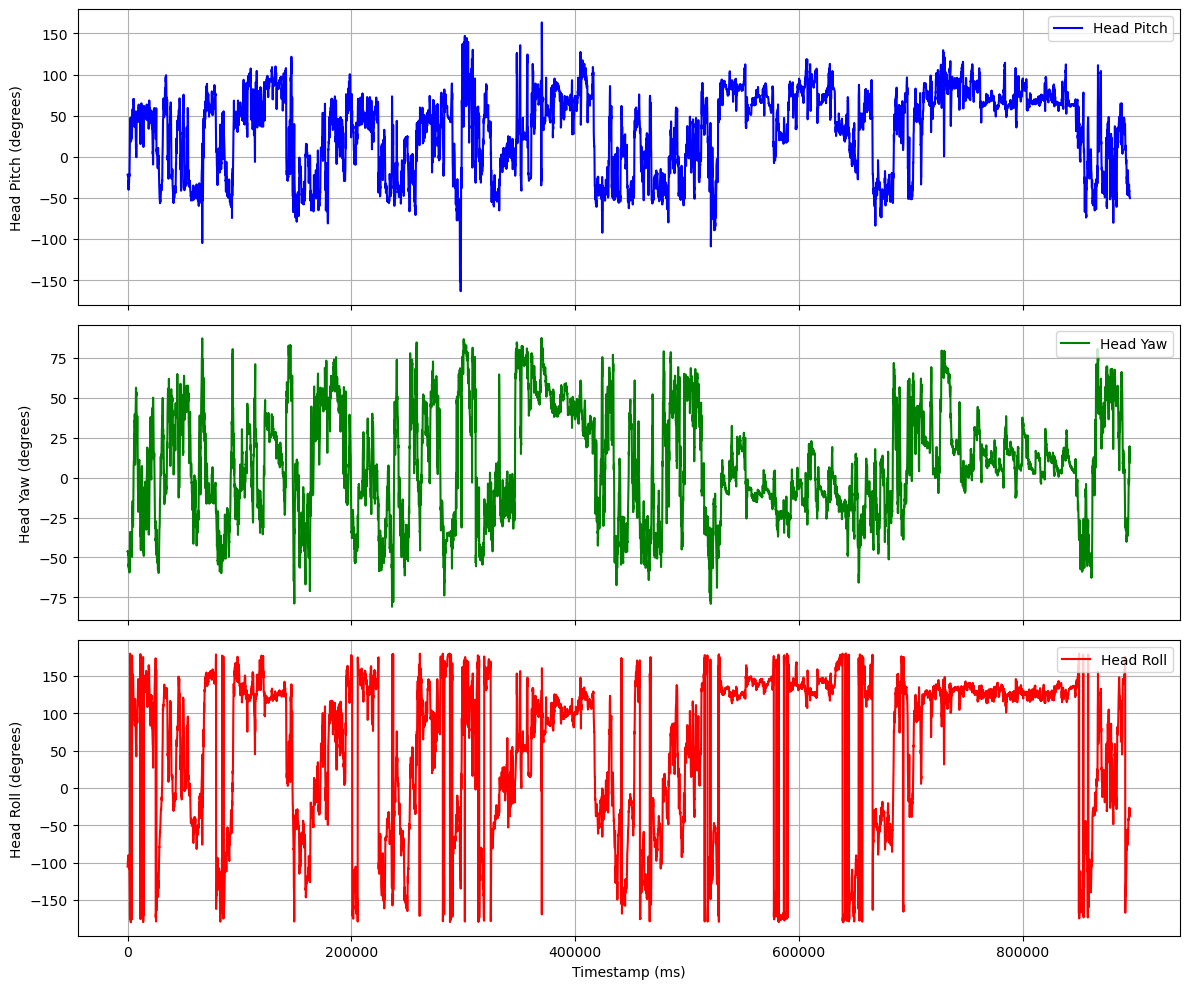

In [31]:
import matplotlib.pyplot as plt
# df_merged_with_dF_F
# Set up the figure and axes
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot head_pitch
ax[0].plot(df_merged_with_dF_F.index, df_merged_with_dF_F['head_pitch'], label='Head Pitch', color='blue')
ax[0].set_ylabel('Head Pitch (degrees)')
ax[0].legend(loc='upper right')
ax[0].grid(True)

# Plot head_yaw
ax[1].plot(df_merged_with_dF_F.index, df_merged_with_dF_F['head_yaw'], label='Head Yaw', color='green')
ax[1].set_ylabel('Head Yaw (degrees)')
ax[1].legend(loc='upper right')
ax[1].grid(True)

# Plot head_roll
ax[2].plot(df_merged_with_dF_F.index, df_merged_with_dF_F['head_roll'], label='Head Roll', color='red')
ax[2].set_xlabel('Timestamp (ms)')
ax[2].set_ylabel('Head Roll (degrees)')
ax[2].legend(loc='upper right')
ax[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# import pandas as pd

# # Modified pairwise_distances function
# def pairwise_distances_from_df(df, keypoints):
#     results = []
#     for _, row in df.iterrows():
#         coords = []
#         # Extract coordinates for each specified keypoint
#         for idx in keypoints:
#             coords.append(np.array([row[f'kp{idx}_x'], row[f'kp{idx}_y'], row[f'kp{idx}_z']]))
        
#         # Calculate pairwise distances
#         distances = [
#             np.linalg.norm(coords[i] - coords[j])
#             for i in range(len(coords))
#             for j in range(i + 1, len(coords))
#         ]
#         results.append(np.mean(distances))  # Store the mean of distances
#     return results

# mean_head = pairwise_distances_from_df(head_coords, head_keypoints)

In [4]:
# import numpy as np

# # head_keypoints = ['kp1', 'kp2', 'kp3', 'kp4']  # EarL, EarR, Snout, SpineF
# # head_coords = df_merged_with_dF_F[[f"{kp}_{axis}" for kp in head_keypoints for axis in ['x', 'y', 'z']]]

# def pairwise_distances(coords):
#     distances = []
#     for i in range(len(coords)):
#         for j in range(i + 1, len(coords)):
#             dist = np.linalg.norm(coords[i] - coords[j])
#             distances.append(dist)
#     return np.mean(distances)

# head_geometry = head_coords.apply(lambda row: pairwise_distances(row.values.reshape(-1, 3)), axis=1)


# avg_geometry = head_geometry.mean()
# template_time = abs(head_geometry - avg_geometry).idxmin()
# template_coords = head_coords.loc[template_time].values.reshape(-1, 3)

# def calculate_centroid(row):
#     return np.mean(row.values.reshape(-1, 3), axis=0)

# # centroids = head_coords.apply(calculate_centroid, axis=1)

# def df_merged_with_dF_F(current, template):
#     centroid_current = np.mean(current, axis=0)
#     centroid_template = np.mean(template, axis=0)

#     current_centered = current - centroid_current
#     template_centered = template - centroid_template

#     H = current_centered.T @ template_centered
#     U, _, Vt = np.linalg.svd(H)
#     R = Vt.T @ U.T

#     if np.linalg.det(R) < 0:
#         Vt[-1, :] *= -1
#         R = Vt.T @ U.T

#     t = centroid_template - R @ centroid_current
#     return R, t

# # Apply to each time point
# transformations = head_coords.apply(
#     lambda row: df_merged_with_dF_F(row.values.reshape(-1, 3), template_coords),
#     axis=1
# )


# from scipy.spatial.transform import Rotation as R

# def get_euler_angles(rotation_matrix):
#     r = R.from_matrix(rotation_matrix)
#     return r.as_euler('xyz', degrees=True)

# angles = transformations.apply(lambda t: get_euler_angles(t[0]))


# # def compute_head_angles(centroid, spineF):
# #     vector = centroid - spineF
# #     pitch = np.arctan2(vector[2], np.sqrt(vector[0]**2 + vector[1]**2))
# #     yaw = np.arctan2(vector[1], vector[0])
# #     return pitch, yaw
# import numpy as np

# def compute_head_angles(centroid, spineF):
#     """
#     Computes head pitch and yaw relative to the body direction.

#     Args:
#         centroid (np.array): Centroid of head markers (3D coordinate).
#         spineF (np.array): Spine Front marker position (3D coordinate).
    
#     Returns:
#         pitch (float): Head pitch angle in radians.
#         yaw (float): Head yaw angle in radians.
#     """
#     # Vector from spineF to centroid
#     vector = centroid - spineF

#     # Compute pitch (vertical tilt relative to horizontal plane)
#     pitch = np.arctan2(vector[2], np.sqrt(vector[0]**2 + vector[1]**2))  # Z vs. horizontal distance

#     # Compute yaw (horizontal rotation around vertical axis)
#     yaw = np.arctan2(vector[1], vector[0])  # Y vs. X

#     return pitch, yaw

In [5]:
# import numpy as np
# from scipy.spatial.transform import Rotation as R

# # Function to compute rigid body transformation and angles
# def rigid_body_transform_with_angles(current, template):
#     # Calculate centroids
#     centroid_current = np.mean(current, axis=0)
#     centroid_template = np.mean(template, axis=0)

#     # Center the data
#     current_centered = current - centroid_current
#     template_centered = template - centroid_template

#     # Compute rotation matrix using SVD
#     H = current_centered.T @ template_centered
#     U, _, Vt = np.linalg.svd(H)
#     R_matrix = Vt.T @ U.T

#     # Ensure a proper rotation matrix (determinant = 1)
#     if np.linalg.det(R_matrix) < 0:
#         Vt[-1, :] *= -1
#         R_matrix = Vt.T @ U.T

#     # Compute translation vector
#     t = centroid_template - R_matrix @ centroid_current

#     # Extract Euler angles (in degrees)
#     rotation = R.from_matrix(R_matrix)
#     angles = rotation.as_euler('xyz', degrees=True)  # Order: pitch, yaw, roll

#     return R_matrix, t, angles

# # Apply the transformation and extract angles for each time point
# results = head_coords.apply(
#     lambda row: rigid_body_transform_with_angles(row.values.reshape(-1, 3), template_coords),
#     axis=1
# )

# # Extract Euler angles into separate columns
# head_coords['head_pitch'] = results.apply(lambda x: x[2][0])  # Pitch
# head_coords['head_yaw'] = results.apply(lambda x: x[2][1])    # Yaw
# head_coords['head_roll'] = results.apply(lambda x: x[2][2])   # Roll


In [77]:
head_coords

,kp1_x,kp1_y,kp1_z,kp2_x,kp2_y,kp2_z,kp3_x,kp3_y,kp3_z,kp4_x,kp4_y,kp4_z,head_pitch,head_yaw,head_roll
timestamp_ms_mini,,,,,,,,,,,,,,,
-28,-28.122872,5.441268,8.643717,-5.780312,25.410323,8.723957,-30.833847,34.114181,-16.471032,-10.986972,8.198104,6.771168,19.477417,29.697125,107.010311
76,-28.854638,5.154164,9.063236,-4.951974,24.577626,8.521851,-30.425599,33.621083,-16.763687,-11.330241,8.100453,7.307989,22.337629,28.602358,109.211765
173,-29.254388,7.589894,10.166833,-4.907010,26.362294,8.815387,-31.746646,35.903859,-16.299432,-12.076773,9.931752,7.914970,23.191844,26.479081,109.557397
284,-27.944006,6.373951,11.351409,-3.278428,24.528065,9.048605,-29.886133,34.246388,-15.412912,-11.572608,9.088429,7.936504,24.783355,24.902347,110.761920
383,-27.555122,6.483571,12.369156,-1.553119,22.777760,9.604132,-30.057277,32.934987,-15.726874,-11.940002,8.715443,7.691933,27.814650,22.554899,112.377244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895154,9.868947,25.779757,1.633460,25.810598,2.765230,5.638701,31.999196,24.972872,-19.237964,9.517202,8.628603,2.156992,35.239824,-18.459907,-170.756493
895262,13.429790,29.775675,2.299765,28.316143,4.591410,5.592223,37.749615,26.356303,-17.804087,12.636333,10.834941,2.745064,31.387888,-19.171462,-165.107359
895354,11.029755,29.117870,3.986044,29.524567,7.389050,6.114741,33.125214,31.308117,-17.494181,12.350312,11.507824,3.239273,33.221603,-16.269555,-175.935781


KeyError: 'head_pitch'

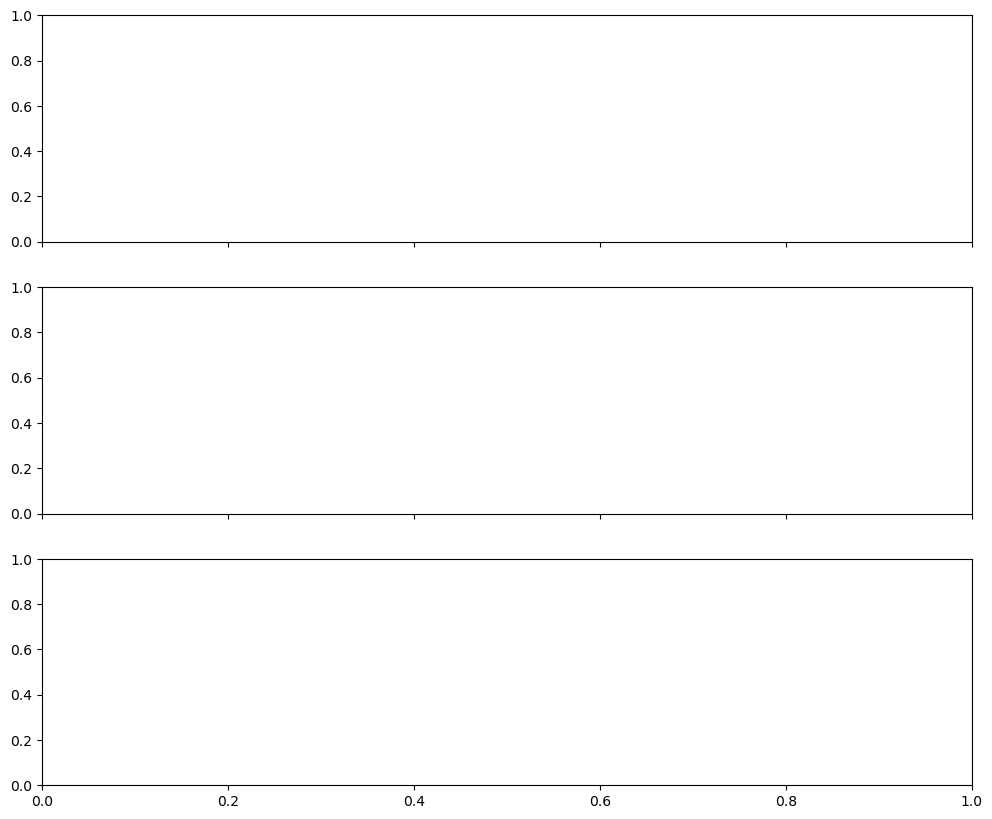

In [ ]:
# import matplotlib.pyplot as plt
# # df_merged_with_dF_F
# # Set up the figure and axes
# fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# # Plot head_pitch
# ax[0].plot(head_coords.index, head_coords['head_pitch'], label='Head Pitch', color='blue')
# ax[0].set_ylabel('Head Pitch (degrees)')
# ax[0].legend(loc='upper right')
# ax[0].grid(True)

# # Plot head_yaw
# ax[1].plot(head_coords.index, head_coords['head_yaw'], label='Head Yaw', color='green')
# ax[1].set_ylabel('Head Yaw (degrees)')
# ax[1].legend(loc='upper right')
# ax[1].grid(True)

# # Plot head_roll
# ax[2].plot(head_coords.index, head_coords['head_roll'], label='Head Roll', color='red')
# ax[2].set_xlabel('Timestamp (ms)')
# ax[2].set_ylabel('Head Roll (degrees)')
# ax[2].legend(loc='upper right')
# ax[2].grid(True)

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [8]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))

rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')




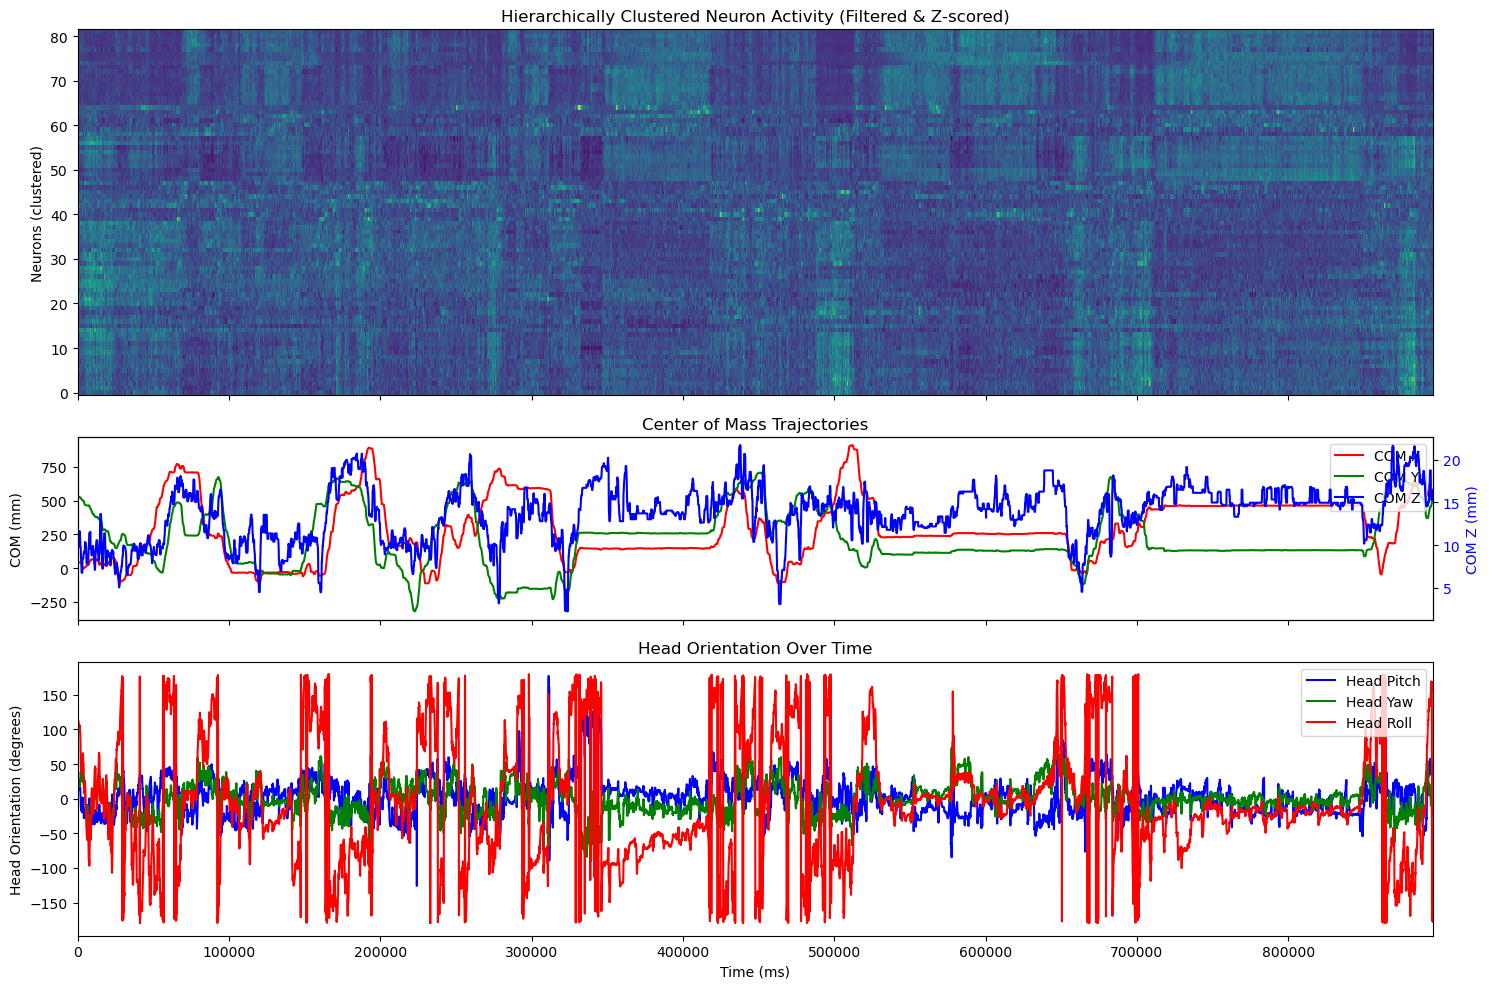

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

df_new = df_merged_with_dF_F

df_new = df_new.reset_index()


time = df_new['timestamp_ms_mini']

# --- Figure & GridSpec ---
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2, 1, 1.5])  # Adjusted for 3 plots

###########################################
# Plot 1 (row 0): Ca²⁺ Heatmap
###########################################
ax1 = fig.add_subplot(gs[0, 0])
if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
    # Hierarchical clustering
    Z = linkage(neuron_activity_normalized, method='ward')
    neuron_order = leaves_list(Z)  # Leaves from dendrogram
    neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
    ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

    # Plot heatmap with pcolormesh
    neuron_indices = np.arange(len(neuron_activity_ordered))
    mesh = ax1.pcolormesh(
        time, neuron_indices, neuron_activity_ordered,
        cmap='viridis', shading='auto'
    )
    ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
    ax1.set_ylabel('Neurons (clustered)')
else:
    print("Neuron activity data not found. Skipping heatmap plot.")
    ax1.text(0.5, 0.5, 'No neuron activity data available.',
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('No Neuron Activity Plot')
ax1.tick_params(labelbottom=False)

###########################################
# Plot 2 (row 1): COM Trajectories
###########################################
# ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
#     ax2.plot(time, df_new['com_x'], color='red', label='COM X')
#     ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
#     ax2.plot(time, df_new['com_z'], color='blue', label='COM Z')
#     ax2.set_ylabel('COM (mm)')
#     ax2.set_title('Center of Mass Trajectories')
#     ax2.legend(loc='upper right')  # Adjust legend position
# else:
#     print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
# ax2.tick_params(labelbottom=False)


ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
    ax2.plot(time, df_new['com_x'], color='red', label='COM X')
    ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
    ax2.set_ylabel('COM (mm)')
    ax2.set_title('Center of Mass Trajectories')
    
    # Create a secondary y-axis for COM Z
    ax2_right = ax2.twinx()
    ax2_right.plot(time, df_new['com_z'], color='blue', label='COM Z')
    ax2_right.set_ylabel('COM Z (mm)', color='blue')
    ax2_right.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends from both axes
    lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
    lines_ax2_right, labels_ax2_right = ax2_right.get_legend_handles_labels()
    ax2.legend(lines_ax2 + lines_ax2_right, labels_ax2 + labels_ax2_right, loc='upper right')
else:
    print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")

ax2.tick_params(labelbottom=False)



###########################################
# Plot 3 (row 2): Head Orientation
###########################################
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
if {'head_pitch', 'head_yaw', 'head_roll'}.issubset(head_coords.columns):
    ax3.plot(time, head_coords['head_pitch'], label='Head Pitch', color='blue')
    ax3.plot(time, head_coords['head_yaw'], label='Head Yaw', color='green')
    ax3.plot(time, head_coords['head_roll'], label='Head Roll', color='red')
    ax3.set_ylabel('Head Orientation (degrees)')
    ax3.set_title('Head Orientation Over Time')
    ax3.legend(loc='upper right')
else:
    print("Head orientation columns not found (head_pitch, head_yaw, head_roll). Check your DataFrame.")

# Final Adjustments
ax3.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()



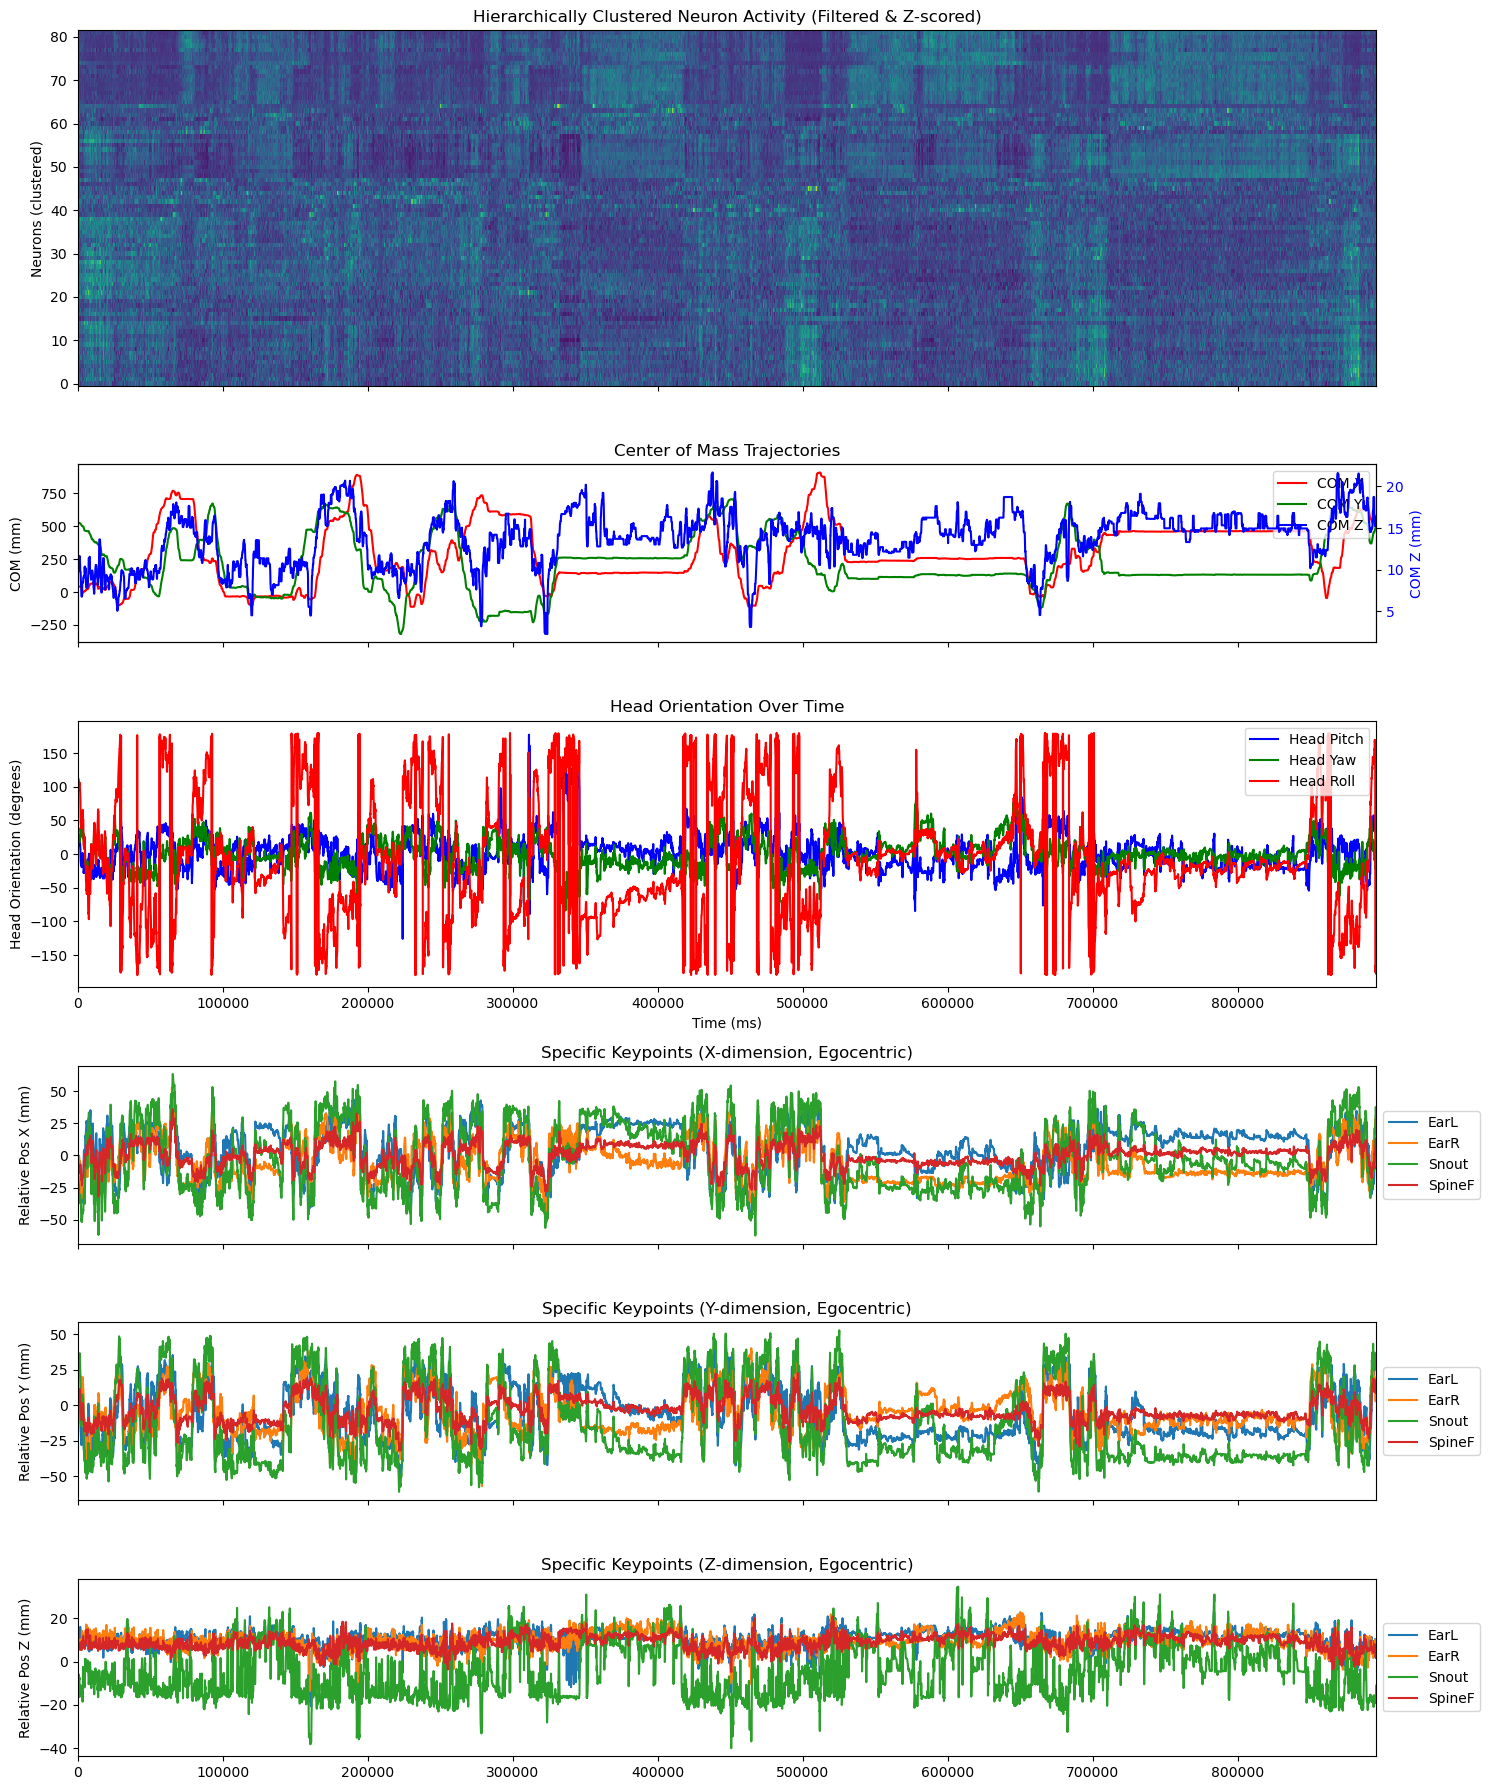

In [19]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

df_new = df_merged_with_dF_F

df_new = df_new.reset_index()
# Define the keypoints and their labels
keypoint_indices = [1, 2, 3, 4]  # Corresponding to 'EarL', 'EarR', 'Snout', 'SpineF'
keypoint_labels = {1: "EarL", 2: "EarR", 3: "Snout", 4: "SpineF"}

location_indices_left = [12, 11, 10, 9]  # Only elbowL, wristL, forepawL
location_labels_left = {
    12: "ShoulderL", 
    11: "ElbowL", 
    10: "WristL", 
    9: "ForepawL"
}


time = df_new['timestamp_ms_mini']

# # --- Figure & GridSpec ---
# fig = plt.figure(figsize=(15, 15))  # Increased height for 5 plots
# gs = fig.add_gridspec(nrows=5, ncols=1, height_ratios=[2, 1, 1.5, 1, 1])  # Adjusted for 5 plots
# fig = plt.figure(figsize=(15, 12))  # Adjusted height for 4 plots
# gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[2, 1, 1.5, 1])  # Adjusted for 4 plots
fig = plt.figure(figsize=(15, 18))  # Increased height for 6 plots
gs = fig.add_gridspec(nrows=6, ncols=1, height_ratios=[2, 1, 1.5, 1, 1, 1])  # Adjusted for 6 plots


###########################################
# Plot 1 (row 0): Ca²⁺ Heatmap
###########################################
ax1 = fig.add_subplot(gs[0, 0])
if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
    # Hierarchical clustering
    Z = linkage(neuron_activity_normalized, method='ward')
    neuron_order = leaves_list(Z)  # Leaves from dendrogram
    neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
    ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

    # Plot heatmap with pcolormesh
    neuron_indices = np.arange(len(neuron_activity_ordered))
    mesh = ax1.pcolormesh(
        time, neuron_indices, neuron_activity_ordered,
        cmap='viridis', shading='auto'
    )
    ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
    ax1.set_ylabel('Neurons (clustered)')
else:
    print("Neuron activity data not found. Skipping heatmap plot.")
    ax1.text(0.5, 0.5, 'No neuron activity data available.',
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('No Neuron Activity Plot')
ax1.tick_params(labelbottom=False)

###########################################
# Plot 2 (row 1): COM Trajectories
###########################################
# ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
#     ax2.plot(time, df_new['com_x'], color='red', label='COM X')
#     ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
#     ax2.plot(time, df_new['com_z'], color='blue', label='COM Z')
#     ax2.set_ylabel('COM (mm)')
#     ax2.set_title('Center of Mass Trajectories')
#     ax2.legend(loc='upper right')  # Adjust legend position
# else:
#     print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
# ax2.tick_params(labelbottom=False)


ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
    ax2.plot(time, df_new['com_x'], color='red', label='COM X')
    ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
    ax2.set_ylabel('COM (mm)')
    ax2.set_title('Center of Mass Trajectories')
    
    # Create a secondary y-axis for COM Z
    ax2_right = ax2.twinx()
    ax2_right.plot(time, df_new['com_z'], color='blue', label='COM Z')
    ax2_right.set_ylabel('COM Z (mm)', color='blue')
    ax2_right.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends from both axes
    lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
    lines_ax2_right, labels_ax2_right = ax2_right.get_legend_handles_labels()
    ax2.legend(lines_ax2 + lines_ax2_right, labels_ax2 + labels_ax2_right, loc='upper right')
else:
    print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")

ax2.tick_params(labelbottom=False)



###########################################
# Plot 3 (row 2): Head Orientation
###########################################
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
if {'head_pitch', 'head_yaw', 'head_roll'}.issubset(head_coords.columns):
    ax3.plot(time, head_coords['head_pitch'], label='Head Pitch', color='blue')
    ax3.plot(time, head_coords['head_yaw'], label='Head Yaw', color='green')
    ax3.plot(time, head_coords['head_roll'], label='Head Roll', color='red')
    ax3.set_ylabel('Head Orientation (degrees)')
    ax3.set_title('Head Orientation Over Time')
    ax3.legend(loc='upper right')
else:
    print("Head orientation columns not found (head_pitch, head_yaw, head_roll). Check your DataFrame.")

# Final Adjustments
ax3.set_xlabel('Time (ms)')



###########################################
# Fourth Plot: X-dimension Egocentric
###########################################
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax4.set_title('Specific Keypoints (X-dimension, Egocentric)')
if 'com_x' in df_new.columns:
    for idx in keypoint_indices:
        x_col = f'kp{idx}_x'
        if x_col in df_new.columns:
            x_ego = df_new[x_col] - df_new['com_x']
            ax4.plot(time, x_ego, label=keypoint_labels[idx])
        else:
            print(f"Warning: {x_col} not found for idx={idx}")
    ax4.set_ylabel('Relative Pos X (mm)')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM X found. Cannot compute egocentric coordinates.")
ax4.tick_params(labelbottom=False)

###########################################
# Fifth Plot: Y-dimension Egocentric
###########################################
ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
ax5.set_title('Specific Keypoints (Y-dimension, Egocentric)')
if 'com_y' in df_new.columns:
    for idx in keypoint_indices:
        y_col = f'kp{idx}_y'
        if y_col in df_new.columns:
            y_ego = df_new[y_col] - df_new['com_y']
            ax5.plot(time, y_ego, label=keypoint_labels[idx])
        else:
            print(f"Warning: {y_col} not found for idx={idx}")
    ax5.set_ylabel('Relative Pos Y (mm)')
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM Y found. Cannot compute egocentric coordinates.")
ax5.tick_params(labelbottom=False)

###########################################
# Sixth Plot: Z-dimension Egocentric
###########################################
ax6 = fig.add_subplot(gs[5, 0], sharex=ax1)
ax6.set_title('Specific Keypoints (Z-dimension, Egocentric)')
if 'com_z' in df_new.columns:
    for idx in keypoint_indices:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            z_ego = df_new[z_col] - df_new['com_z']
            ax6.plot(time, z_ego, label=keypoint_labels[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax6.set_ylabel('Relative Pos Z (mm)')
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM Z found. Cannot compute egocentric coordinates.")
ax6.tick_params(labelbottom=True)
ax6.set_xlabel('Time (ms)')


plt.tight_layout()
plt.show()


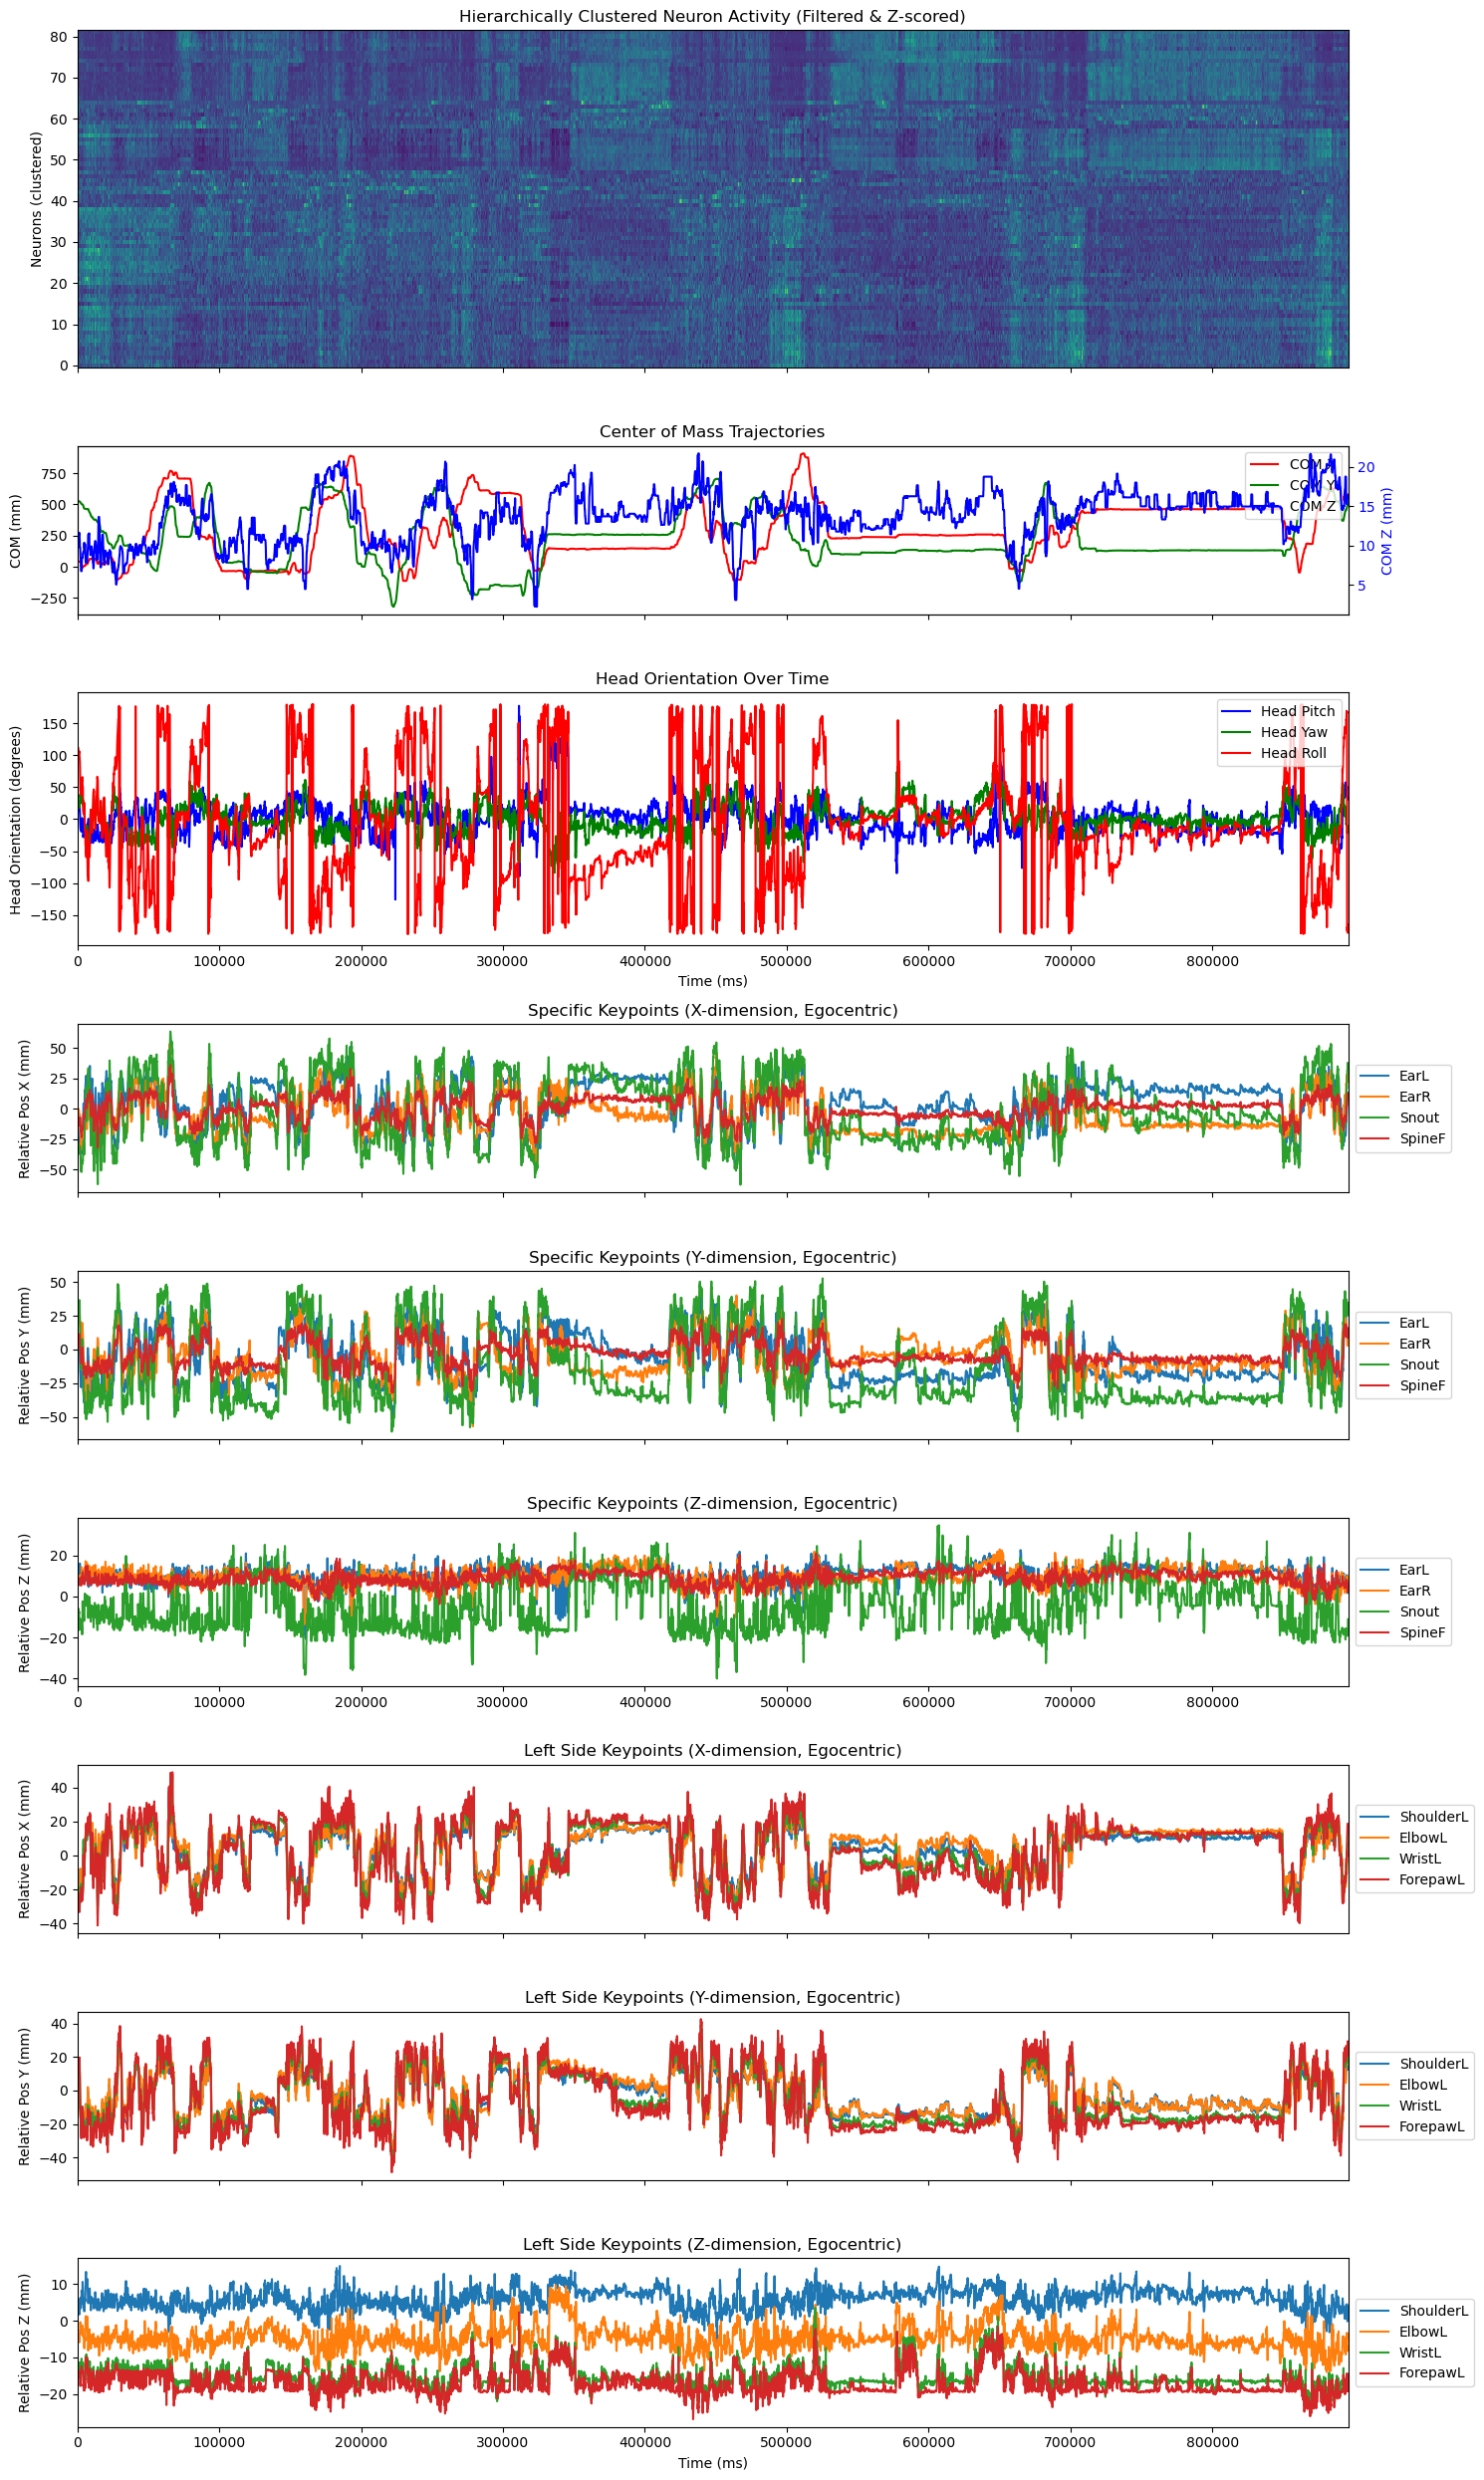

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

df_new = df_merged_with_dF_F

df_new = df_new.reset_index()
# Define the keypoints and their labels
keypoint_indices = [1, 2, 3, 4]  # Corresponding to 'EarL', 'EarR', 'Snout', 'SpineF'
keypoint_labels = {1: "EarL", 2: "EarR", 3: "Snout", 4: "SpineF"}

location_indices_left = [12, 11, 10, 9]  # Only elbowL, wristL, forepawL
location_labels_left = {
    12: "ShoulderL", 
    11: "ElbowL", 
    10: "WristL", 
    9: "ForepawL"
}


time = df_new['timestamp_ms_mini']

# # --- Figure & GridSpec ---
# fig = plt.figure(figsize=(15, 15))  # Increased height for 5 plots
# gs = fig.add_gridspec(nrows=5, ncols=1, height_ratios=[2, 1, 1.5, 1, 1])  # Adjusted for 5 plots
# fig = plt.figure(figsize=(15, 12))  # Adjusted height for 4 plots
# gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[2, 1, 1.5, 1])  # Adjusted for 4 plots
# fig = plt.figure(figsize=(15, 18))  # Increased height for 6 plots
# gs = fig.add_gridspec(nrows=9, ncols=1, height_ratios=[2, 1, 1.5, 1, 1, 1])  # Adjusted for 6 plots
fig = plt.figure(figsize=(15, 25))  # Adjusted height for 9 plots
gs = fig.add_gridspec(nrows=9, ncols=1, height_ratios=[2, 1, 1.5, 1, 1, 1, 1, 1, 1])  # Adjusted for 9 plots


###########################################
# Plot 1 (row 0): Ca²⁺ Heatmap
###########################################
ax1 = fig.add_subplot(gs[0, 0])
if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
    # Hierarchical clustering
    Z = linkage(neuron_activity_normalized, method='ward')
    neuron_order = leaves_list(Z)  # Leaves from dendrogram
    neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
    ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

    # Plot heatmap with pcolormesh
    neuron_indices = np.arange(len(neuron_activity_ordered))
    mesh = ax1.pcolormesh(
        time, neuron_indices, neuron_activity_ordered,
        cmap='viridis', shading='auto'
    )
    ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
    ax1.set_ylabel('Neurons (clustered)')
else:
    print("Neuron activity data not found. Skipping heatmap plot.")
    ax1.text(0.5, 0.5, 'No neuron activity data available.',
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('No Neuron Activity Plot')
ax1.tick_params(labelbottom=False)

###########################################
# Plot 2 (row 1): COM Trajectories
###########################################
# ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
#     ax2.plot(time, df_new['com_x'], color='red', label='COM X')
#     ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
#     ax2.plot(time, df_new['com_z'], color='blue', label='COM Z')
#     ax2.set_ylabel('COM (mm)')
#     ax2.set_title('Center of Mass Trajectories')
#     ax2.legend(loc='upper right')  # Adjust legend position
# else:
#     print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
# ax2.tick_params(labelbottom=False)


ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
    ax2.plot(time, df_new['com_x'], color='red', label='COM X')
    ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
    ax2.set_ylabel('COM (mm)')
    ax2.set_title('Center of Mass Trajectories')
    
    # Create a secondary y-axis for COM Z
    ax2_right = ax2.twinx()
    ax2_right.plot(time, df_new['com_z'], color='blue', label='COM Z')
    ax2_right.set_ylabel('COM Z (mm)', color='blue')
    ax2_right.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends from both axes
    lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
    lines_ax2_right, labels_ax2_right = ax2_right.get_legend_handles_labels()
    ax2.legend(lines_ax2 + lines_ax2_right, labels_ax2 + labels_ax2_right, loc='upper right')
else:
    print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")

ax2.tick_params(labelbottom=False)



###########################################
# Plot 3 (row 2): Head Orientation
###########################################
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
if {'head_pitch', 'head_yaw', 'head_roll'}.issubset(head_coords.columns):
    ax3.plot(time, head_coords['head_pitch'], label='Head Pitch', color='blue')
    ax3.plot(time, head_coords['head_yaw'], label='Head Yaw', color='green')
    ax3.plot(time, head_coords['head_roll'], label='Head Roll', color='red')
    ax3.set_ylabel('Head Orientation (degrees)')
    ax3.set_title('Head Orientation Over Time')
    ax3.legend(loc='upper right')
else:
    print("Head orientation columns not found (head_pitch, head_yaw, head_roll). Check your DataFrame.")

# Final Adjustments
ax3.set_xlabel('Time (ms)')



###########################################
# Fourth Plot: X-dimension Egocentric
###########################################
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax4.set_title('Specific Keypoints (X-dimension, Egocentric)')
if 'com_x' in df_new.columns:
    for idx in keypoint_indices:
        x_col = f'kp{idx}_x'
        if x_col in df_new.columns:
            x_ego = df_new[x_col] - df_new['com_x']
            ax4.plot(time, x_ego, label=keypoint_labels[idx])
        else:
            print(f"Warning: {x_col} not found for idx={idx}")
    ax4.set_ylabel('Relative Pos X (mm)')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM X found. Cannot compute egocentric coordinates.")
ax4.tick_params(labelbottom=False)

###########################################
# Fifth Plot: Y-dimension Egocentric
###########################################
ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
ax5.set_title('Specific Keypoints (Y-dimension, Egocentric)')
if 'com_y' in df_new.columns:
    for idx in keypoint_indices:
        y_col = f'kp{idx}_y'
        if y_col in df_new.columns:
            y_ego = df_new[y_col] - df_new['com_y']
            ax5.plot(time, y_ego, label=keypoint_labels[idx])
        else:
            print(f"Warning: {y_col} not found for idx={idx}")
    ax5.set_ylabel('Relative Pos Y (mm)')
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM Y found. Cannot compute egocentric coordinates.")
ax5.tick_params(labelbottom=False)

###########################################
# Sixth Plot: Z-dimension Egocentric
###########################################
ax6 = fig.add_subplot(gs[5, 0], sharex=ax1)
ax6.set_title('Specific Keypoints (Z-dimension, Egocentric)')
if 'com_z' in df_new.columns:
    for idx in keypoint_indices:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            z_ego = df_new[z_col] - df_new['com_z']
            ax6.plot(time, z_ego, label=keypoint_labels[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax6.set_ylabel('Relative Pos Z (mm)')
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM Z found. Cannot compute egocentric coordinates.")


###########################################
# Plot: Left Side Keypoints (X-dimension, Egocentric)
###########################################
ax7 = fig.add_subplot(gs[6, 0], sharex=ax1)
ax7.set_title('Left Side Keypoints (X-dimension, Egocentric)')
if 'com_x' in df_new.columns:
    for idx in location_indices_left:
        x_col = f'kp{idx}_x'
        if x_col in df_new.columns:
            x_ego = df_new[x_col] - df_new['com_x']
            ax7.plot(time, x_ego, label=location_labels_left[idx])
        else:
            print(f"Warning: {x_col} not found for idx={idx}")
    ax7.set_ylabel('Relative Pos X (mm)')
    ax7.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM X found. Cannot compute egocentric coordinates.")
ax7.tick_params(labelbottom=False)

###########################################
# Plot: Left Side Keypoints (Y-dimension, Egocentric)
###########################################
ax8 = fig.add_subplot(gs[7, 0], sharex=ax1)
ax8.set_title('Left Side Keypoints (Y-dimension, Egocentric)')
if 'com_y' in df_new.columns:
    for idx in location_indices_left:
        y_col = f'kp{idx}_y'
        if y_col in df_new.columns:
            y_ego = df_new[y_col] - df_new['com_y']
            ax8.plot(time, y_ego, label=location_labels_left[idx])
        else:
            print(f"Warning: {y_col} not found for idx={idx}")
    ax8.set_ylabel('Relative Pos Y (mm)')
    ax8.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM Y found. Cannot compute egocentric coordinates.")
ax8.tick_params(labelbottom=False)

###########################################
# Plot: Left Side Keypoints (Z-dimension, Egocentric)
###########################################
ax9 = fig.add_subplot(gs[8, 0], sharex=ax1)
ax9.set_title('Left Side Keypoints (Z-dimension, Egocentric)')
if 'com_z' in df_new.columns:
    for idx in location_indices_left:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            z_ego = df_new[z_col] - df_new['com_z']
            ax9.plot(time, z_ego, label=location_labels_left[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax9.set_ylabel('Relative Pos Z (mm)')
    ax9.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    print("No COM Z found. Cannot compute egocentric coordinates.")
ax9.tick_params(labelbottom=True)

ax9.set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()


In [66]:
df_merged_with_dF_F

,com_x,com_y,com_z,kp1_x,kp1_y,kp1_z,kp2_x,kp2_y,kp2_z,kp3_x,...,dF_F_roi77,dF_F_roi78,dF_F_roi79,dF_F_roi80,dF_F_roi81,dF_F_roi82,dF_F_roi83,dF_F_roi84,dF_F_roi85,dF_F_roi86
timestamp_ms_mini,,,,,,,,,,,,,,,,,,,,,
-28,41.706841,527.997575,10.797444,13.583969,533.438843,19.441160,35.926529,553.407898,19.521400,10.872994,...,5.450978,0.820760,1.868120,0.456811,1.014832,1.502012,2.116763,4.093864,-0.077933,0.503355
76,41.555597,528.230113,9.798887,12.700958,533.384277,18.862123,36.603622,552.807739,18.320738,11.129997,...,4.451628,0.938705,1.827905,0.178854,1.074192,1.681203,2.263206,3.354450,-0.027647,0.689176
173,41.311852,528.230113,9.676444,12.057464,535.820007,19.843277,36.404842,554.592407,18.491831,9.565206,...,3.323933,0.936644,1.776339,0.431037,1.219960,1.304163,1.663213,1.884310,0.063689,0.471626
284,41.311852,528.230113,9.676444,13.367846,534.604065,21.027853,38.033424,552.758179,18.725048,11.425719,...,3.754166,1.546126,2.289237,0.665953,1.346383,1.647476,2.277503,1.947350,0.081327,0.852772
383,41.070991,528.230113,9.798887,13.515869,534.713684,22.168043,39.517872,551.007874,19.403019,11.013714,...,3.008973,1.027965,1.807050,0.314316,1.866527,1.861826,2.073067,2.633667,0.038555,0.634334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895154,561.426280,491.163603,16.114240,571.295227,516.943359,17.747700,587.236877,493.928833,21.752941,593.425476,...,2.471127,-0.212385,0.395668,0.431881,0.664789,0.294658,0.583652,-0.117043,1.580501,0.633466
895262,565.447285,492.621053,16.114240,578.877075,522.396729,18.414005,593.763428,497.212463,21.706463,603.196899,...,0.593495,0.637050,0.732832,0.356040,0.354433,0.338199,0.067821,-0.772679,1.327936,0.584110
895354,571.293731,496.557728,16.212091,582.323486,525.675598,20.198135,600.818298,503.946777,22.326832,604.418945,...,2.264685,1.084643,0.529707,0.489709,0.657618,0.661684,0.214412,-0.757433,1.044665,0.846073
